In [2]:
import numpy as np 
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from functools import partial
import torchvision
from tqdm import trange, tqdm
import os 
import glob
import time
import copy
import random
from PIL import Image, ImageOps, ImageFilter

os.environ['CUDA_VISIBLE_DEVICES']='0'
device = torch.device('cpu')

In [3]:
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams['figure.dpi'] = 72
plt.rcParams['figure.figsize'] = [6.0, 4.0]
plt.rcParams['figure.edgecolor'] = (1, 1, 1, 0)
plt.rcParams['figure.facecolor'] = (1, 1, 1, 0)

In [4]:
import einops

In [52]:
def get_XOR(x1, x2): 
    x3 = []
    for i in x1:
        if i not in x2: 
            x3.append(i)
    for j in x2: 
        if j not in x1: 
            x3.append(j)
    x3 = np.sort(x3)
    return list(x3)

def get_OR(x1, x2): 
    x3 = []
    for i in x1: 
        x3.append(i)
    for j in x2: 
        if j not in x3: 
            x3.append(j)
    x3 = np.sort(x3)
    return list(x3) 

def get_AND(x1, x2): 
    x3 = []
    for i in x1: 
        if i in x2: 
            x3.append(i)
    x3 = np.sort(x3)
    return list(x3) 

d_list = [0, -2, -1, 1, 2]

def check_R_unique(a_list):
    """a_list e.g., [1, 1, 1]"""
    a1, a2, a3 = a_list
    d1, d2 = a2-a1, a3-a2
    if d1 == d2: # constant or progression 
        if d1 in d_list: 
            i_R = d_list.index(d1)
        elif a3 == a1+a2: # arith pos 
            i_R = 5 
        elif a3 == a1-a2: # arith neg 
            i_R = 6 
        else: 
            i_R = np.nan
    else: 
        i_R = np.nan 
    return i_R 

def check_R_logical(attr_unique_row): 
    """attr_unique_row: list of len 3, unique attr values for each panel, e.g., [[0, 3], [1], [0, 5]]"""
    [x1, x2, x3] = attr_unique_row
    if x3 == get_XOR(x1, x2): 
        i_R = 7 
    elif x3 == get_XOR(x1, x2): 
        i_R = 8 
    elif x3 == get_AND(x1, x2): 
        i_R = 9 
    else: 
        i_R = np.nan 
    return i_R

def check_R(attr_unique_row): 

    if [len(x) for x in attr_unique_row] == [1, 1, 1]: # check for const, prog, arith 
        i_R = check_R_unique([x[0] for x in attr_unique_row])
    else: 
        i_R = check_R_logical(attr_unique_row)
    return i_R

def get_obj_list(attr):
    """
    for each panel, convert to list of objects: (shape, size, color, pos)
    Inputs: 
        attr: (3, 9, 3), # (num_panels, num_pos, num_attr)
    """
    attr_list_row = []
    pos_row = []

    for i_panel in range(3): 

        attr_panel = attr[i_panel] # torch.Size([9, 3])
        pos = ((attr_panel==-1).sum(1)==0).nonzero().squeeze(1)
        pos_row.append(list(pos.numpy()))

        attr_list = attr_panel[pos]
        attr_list_row.append(attr_list)
    return attr_list_row, pos_row

def get_rule_list(attr_list_row, pos_row): 
    """check for rules"""
    rule_list = []
    for i_a in range(3): # shape, constant, color
        attr_unique_row = [list(torch.unique(attr_list[:,i_a]).numpy()) for attr_list in attr_list_row]
        i_R = check_R(attr_unique_row)
        if not np.isnan(i_R): 
            rule_list.append(i_a*10+i_R)

    # check for number 
    num_row = [len(x) for x in attr_list_row]
    i_R = check_R_unique(num_row)
    if not np.isnan(i_R): 
        rule_list.append(30+i_R)
        
    # check for position 
    i_R = check_R_logical(pos_row)
    if not np.isnan(i_R): 
        rule_list.append(30+i_R)
        
    if len(rule_list) != 1: 
        rule = -1
    else: 
        rule = rule_list[0]
        
    return rule 

def get_rule_img(attr_tsr):
    """get rules list for an image of 3 rows"""
    row_num = attr_tsr.size(1)//3
    rule_all = []
    for i_row in range(row_num): 
        attr_row = attr_tsr[:,3*i_row:3*(i_row+1),:] # torch.Size([3, 3, 9])
        attr = einops.rearrange(attr_row, 'attr h (p w) -> p (h w) attr', h=3,w=3,p=3) # (3, 9, 3)
        attr_list_row, pos_row = get_obj_list(attr)
        rule = get_rule_list(attr_list_row, pos_row)
        rule_all.append(rule)
    return np.asarray(rule_all)

In [169]:
def onehot2attr_tsr(samples, dim=10, threshold=0.5):
    attr0_onehot, attr0 = samples[:,  0:7].max(dim=1)
    attr0[attr0_onehot < threshold] = -1
    attr1_onehot, attr1 = samples[:,  7:17].max(dim=1)
    attr1[attr1_onehot < threshold] = -1
    attr2_onehot, attr2 = samples[:, 17:27].max(dim=1)
    attr2[attr2_onehot < threshold] = -1
    attr_tsr = torch.stack((attr0, attr1, attr2), dim=1)
    return attr_tsr

In [ ]:
def check_consistent(rules):
    # if all 3 rows have the same rule, and it's not -1, return 1
    # if two rows have the same rule, and it's not -1, return 2
    # else, return 0
    rule_all = np.asarray(rules)
    rule_all = rule_all[rule_all != -1]
    if len(rule_all) == 0: # [-1, -1, -1]
        return 0
    elif len(np.unique(rule_all)) == 1 and len(rule_all) == 3: # three of a kind
        return 1
    # elif len(np.unique(rule_all)) == 1 and len(rule_all) == 2: # two of a kind, and the other is -1
    #     return 2
    elif len(np.unique(rule_all)) < len(rule_all): # two of a kind, [2, 1] or 2
        return 2
    else: 
        return 3 # anything else 
    

In [ ]:
from edm_utils import parse_train_logfile
from os.path import join
import re
import pandas as pd
def parse_train_logfile(logfile_path):
    # logfile = "/n/home12/binxuwang/Github/mini_edm/exps/base_mnist_20240129-1342/std.log"
    # Define the regex pattern to extract the desired information
    # pattern = r"(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}) - (\w+): (.*)"
    pattern = r"(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})\s+(\w+)\s+-->\s+step:\s+(\d+),\s+current lr:\s+([\d.]+)\s+average loss:\s+([\d.]+);\s+batch loss:\s+([\d.]+)"

    # Create empty lists to store the extracted information
    df_col = []
    # Read the logfile line by line and extract the desired information
    with open(logfile_path, "r") as file:
        for line in file:
            match = re.match(pattern, line)
            if match:
                timestamp = match.group(1)
                level = match.group(2)
                step = match.group(3)
                learning_rate = match.group(4)
                average_loss = match.group(5)
                batch_loss = match.group(6)
                df_col.append({"timestamp": timestamp, "level": level, "step": int(step),
                                "learning_rate": float(learning_rate), "average_loss": float(average_loss),
                                "batch_loss": float(batch_loss),})

    # Create a pandas dataframe from the extracted information
    df = pd.DataFrame(df_col)
    # Display the dataframe
    print(df.head())
    return df


In [7]:
epoch_list = list(np.arange(0, 100000, 500))
epoch_list.append(99999)

### One-hot encoding, Abstract model result

In [89]:
expdir = "/n/home12/binxuwang/Github/mini_edm/exps/base_RAVEN10_abstract_onehot_20240201-0147/samples"
rules_all_onehot = []
for epoch in epoch_list: 
    # samples = torch.load('data/20240203_01_Binxu_samples/tensor_'+str(epoch)+'.pt')
    samples = torch.load(expdir+'/tensor_'+str(epoch)+'.pt') # (batch, 27, 9, 9)
    attr_tsr_list = onehot2attr_tsr(samples) # (batch, 3, 9, 9)
    rules_list = []
    for i, attr_tsr in enumerate(attr_tsr_list): 
        rule_img = get_rule_img(attr_tsr) # (3, 9, 9) -> (3,)
        rules_list.append(rule_img)
    rules_all_onehot.append(rules_list)
rules_all_onehot = np.asarray(rules_all_onehot) # (201, 25, 3)

In [14]:
rules_sum = (rules_all != -1).sum(2)

Text(0.5, 0, 'epoch')

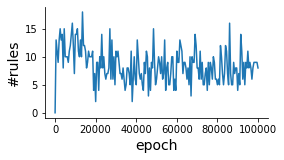

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(4,2))
ax.spines[['right', 'top']].set_visible(False)

ax.plot(epoch_list, rules_sum.sum(1))

ax.set_ylabel('#rules', fontsize=14)
ax.set_xlabel('epoch', fontsize=14)

Text(0.5, 1.0, 'Abstract One-hot feature encoding, uncond Diffusion')

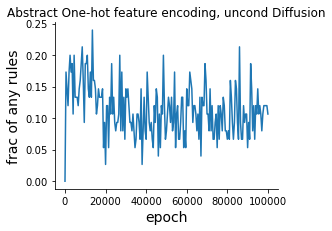

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(4,3))
ax.spines[['right', 'top']].set_visible(False)

ax.plot(epoch_list, (rules_all_onehot != -1).mean(axis=(1,2)))

ax.set_ylabel('frac of any rules', fontsize=14)
ax.set_xlabel('epoch', fontsize=14)
ax.set_title("Abstract One-hot feature encoding, uncond Diffusion")

### Digit feature encoding, Abstract model result

In [87]:
expdir = "/n/home12/binxuwang/Github/mini_edm/exps/base_RAVEN10_20240201-0036/samples"
rules_all_digit = []
for epoch in epoch_list: 
    samples = torch.load(expdir+'/tensor_'+str(epoch)+'.pt') # (batch, 3, 9, 9)
    attr_tsr_list = torch.round(samples).int() # (batch, 3, 9, 9)
    rules_list = []
    for i, attr_tsr in enumerate(attr_tsr_list): 
        rule_img = get_rule_img(attr_tsr) # (3, 9, 9) -> (3,)
        rules_list.append(rule_img)
    rules_all_digit.append(rules_list)
rules_all_digit = np.asarray(rules_all_digit) # (201, 25, 3)

Text(0.5, 1.0, 'Abstract Digit feature encoding, uncond Diffusion')

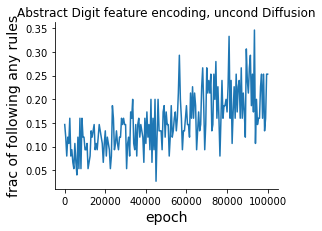

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(4,3))
ax.spines[['right', 'top']].set_visible(False)
ax.plot(epoch_list, (rules_all_digit != -1).mean(axis=(1,2)))
ax.set_ylabel('frac of following any rules', fontsize=14)
ax.set_xlabel('epoch', fontsize=14)
ax.set_title("Abstract Digit feature encoding, uncond Diffusion")

In [96]:
rules_all_digit.shape

(201, 25, 3)

In [114]:
consistent_mat = []
for epoch_i in range(len(epoch_list)): 
    rules_all = rules_all_digit[epoch_i]
    consistent_all = [check_consistent(rules) for rules in rules_all]
    consistent_mat.append(consistent_all)
consistent_mat = np.asarray(consistent_mat)

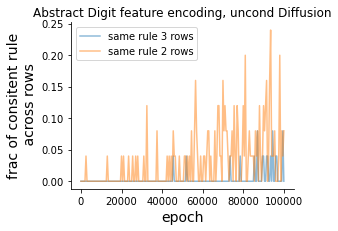

In [117]:

fig, ax = plt.subplots(1, 1, figsize=(4,3))
ax.spines[['right', 'top']].set_visible(False)
ax.plot(epoch_list, (consistent_mat == 1).mean(axis=(1)), alpha=0.5, label="same rule 3 rows")
ax.plot(epoch_list, (consistent_mat == 2).mean(axis=(1)), alpha=0.5, label="same rule 2 rows")
ax.set_ylabel('frac of consitent rule\n across rows', fontsize=14)
ax.set_xlabel('epoch', fontsize=14)
ax.set_title("Abstract Digit feature encoding, uncond Diffusion")
ax.legend()

### Digit feature encoding, wide model, more samples

In [ ]:
import scipy.stats as stats

def estimate_CI(count, total, alpha=0.05):
    """estimate the confidence interval of a ratio"""
    p = count / total
    n = total
    lower = stats.binom.ppf(alpha/2, n, p)
    upper = stats.binom.ppf(1-alpha/2, n, p)
    return lower/n, upper/n


def shaded_error(ax, x, y, yerr_low, yerr_high, label=None, color=None, alpha=0.3):
    ax.plot(x, y, label=label, color=color)
    ax.fill_between(x, yerr_low, yerr_high, alpha=alpha, color=color)


In [179]:
from tqdm import trange, tqdm

In [180]:
expdir = "/n/holylabs/LABS/kempner_fellows/Users/binxuwang/DL_Projects/mini_edm/exps/Wide_RAVEN10_abstract_20240206-2323/samples"
epoch_list = list(np.arange(0, 1000000, 5000))
rules_all_digit_wide = []
for epoch in tqdm(epoch_list): 
    if not os.path.exists(expdir+'/tensor_'+str(epoch)+'.pt'):
        print(epoch, "not exist")
        break
    samples = torch.load(expdir+'/tensor_'+str(epoch)+'.pt') # (batch, 3, 9, 9)
    attr_tsr_list = torch.round(samples).int() # (batch, 3, 9, 9)
    rules_list = []
    for i, attr_tsr in enumerate(attr_tsr_list): 
        rule_img = get_rule_img(attr_tsr) # (3, 9, 9) -> (3,)
        rules_list.append(rule_img)
    rules_all_digit_wide.append(rules_list)
rules_all_digit_wide = np.asarray(rules_all_digit_wide) # (201, 25, 3)

consistent_mat_wide = []
for epoch_i in trange(len(rules_all_digit_wide)): 
    rules_all = rules_all_digit_wide[epoch_i]
    consistent_all = [check_consistent(rules) for rules in rules_all]
    consistent_mat_wide.append(consistent_all)
consistent_mat_wide = np.asarray(consistent_mat_wide)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.55it/s]


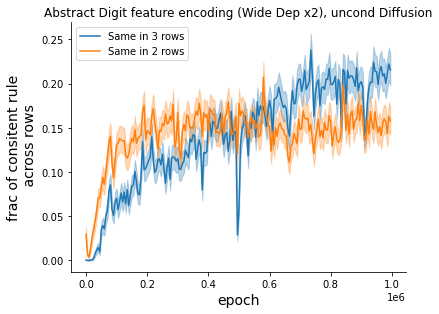

In [182]:
fig, ax = plt.subplots(1, 1, figsize=(6,4.5))
ax.spines[['right', 'top']].set_visible(False)
epoch_list = epoch_list[:len(consistent_mat_wide)]
CI_low, CI_high = estimate_CI((consistent_mat_wide == 1).sum(axis=1), 2048, alpha=0.05)
shaded_error(plt.gca(), epoch_list, (consistent_mat_wide == 1).mean(axis=1),
                CI_low, CI_high, label="Same in 3 rows", color="C0")
CI_low, CI_high = estimate_CI((consistent_mat_wide == 2).sum(axis=1), 2048, alpha=0.05)
shaded_error(plt.gca(), epoch_list, (consistent_mat_wide==2).mean(axis=1),
                CI_low, CI_high, label="Same in 2 rows", color="C1")
ax.set_ylabel('frac of consitent rule\n across rows', fontsize=14)
ax.set_xlabel('epoch', fontsize=14)
ax.set_title("Abstract Digit feature encoding (Wide Dep x2), uncond Diffusion")
ax.legend()
fig.savefig("Figures/RAVEN10_abstract_Wide_rule_consistency.pdf", dpi=300, )#bbox_inches='tight')
fig.savefig("Figures/RAVEN10_abstract_Wide_rule_consistency.png", dpi=300, )#bbox_inches='tight')

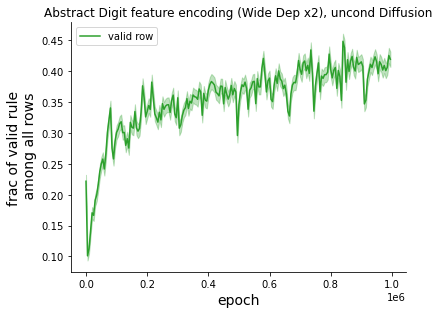

In [183]:
fig, ax = plt.subplots(1, 1, figsize=(6,4.5))
ax.spines[['right', 'top']].set_visible(False)
epoch_list = epoch_list[:len(consistent_mat_wide)]
CI_low, CI_high = estimate_CI((rules_all_digit_wide != -1).sum(axis=(1,2)), 2048 * 3, alpha=0.05)
shaded_error(plt.gca(), epoch_list, (rules_all_digit_wide != -1).mean(axis=(1,2)),
                CI_low, CI_high, label="valid row", color="C2")
ax.set_ylabel('frac of valid rule\n among all rows', fontsize=14)
ax.set_xlabel('epoch', fontsize=14)
ax.set_title("Abstract Digit feature encoding (Wide Dep x2), uncond Diffusion")
ax.legend()
fig.savefig("Figures/RAVEN10_abstract_Wide_rule_valid.pdf", dpi=300, )#bbox_inches='tight')
fig.savefig("Figures/RAVEN10_abstract_Wide_rule_valid.png", dpi=300, )#bbox_inches='tight')

             timestamp level  step  learning_rate  average_loss  batch_loss
0  2024-02-06 23:24:33  INFO     0       0.000000      1.933217    1.933217
1  2024-02-06 23:24:41  INFO   100       0.000004      2.040321    2.044233
2  2024-02-06 23:24:47  INFO   200       0.000008      1.974165    1.897349
3  2024-02-06 23:24:52  INFO   300       0.000012      1.907248    1.712826
4  2024-02-06 23:24:58  INFO   400       0.000016      1.838222    1.622334


<Axes: xlabel='step'>

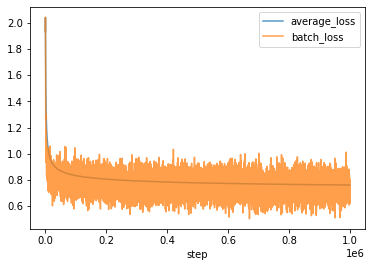

In [190]:
expdir = "/n/holylabs/LABS/kempner_fellows/Users/binxuwang/DL_Projects/mini_edm/exps/Wide_RAVEN10_abstract_20240206-2323/samples"
df = parse_train_logfile(join(expdir, "..", "std.log"))
df.plot(x="step", y=["average_loss","batch_loss"], alpha=0.75)

In [192]:
from os.path import join
np.savez(join(expdir,"samples_inferred_rule_consistency.npz"), 
         consistent_mat=consistent_mat_wide, 
         rules_all=rules_all_digit_wide,
         epoch_list=epoch_list)

#### Obsolete plots

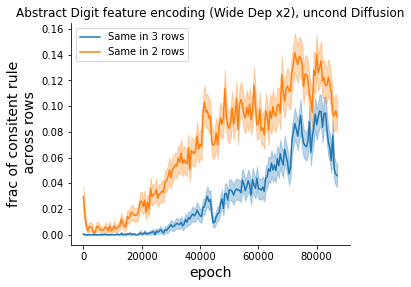

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.spines[['right', 'top']].set_visible(False)
CI_low, CI_high = estimate_CI((consistent_mat_wide == 1).sum(axis=1), 2048, alpha=0.05)
shaded_error(plt.gca(), epoch_list[:len(consistent_mat_wide)], (consistent_mat_wide == 1).mean(axis=1),
                CI_low, CI_high, label="Same in 3 rows", color="C0")
CI_low, CI_high = estimate_CI((consistent_mat_wide == 2).sum(axis=1), 2048, alpha=0.05)
shaded_error(plt.gca(), epoch_list[:len(consistent_mat_wide)], (consistent_mat_wide==2).mean(axis=1),
                CI_low, CI_high, label="Same in 2 rows", color="C1")
# ax.plot(epoch_list[:len(consistent_mat_wide)], 
#   (consistent_mat_wide == 1).mean(axis=(1)), alpha=0.5, label="same rule 3 rows")
# ax.plot(epoch_list[:len(consistent_mat_wide)], 
#   (consistent_mat_wide == 2).mean(axis=(1)), alpha=0.5, label="same rule 2 rows")
ax.set_ylabel('frac of consitent rule\n across rows', fontsize=14)
ax.set_xlabel('epoch', fontsize=14)
ax.set_title("Abstract Digit feature encoding (Wide Dep x2), uncond Diffusion")
ax.legend()
fig.savefig("Figures/RAVEN10_abstract_Wide_rule_consistency.pdf", dpi=300, )#bbox_inches='tight')
fig.savefig("Figures/RAVEN10_abstract_Wide_rule_consistency.png", dpi=300, )#bbox_inches='tight')

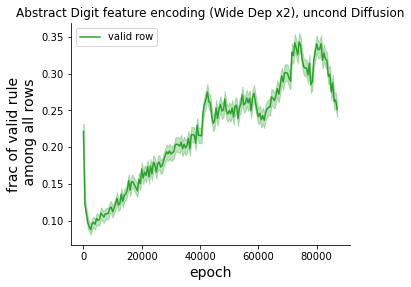

In [146]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.spines[['right', 'top']].set_visible(False)
CI_low, CI_high = estimate_CI((rules_all_digit_wide != -1).sum(axis=(1,2)), 2048 * 3, alpha=0.05)
shaded_error(plt.gca(), epoch_list[:len(consistent_mat_wide)], (rules_all_digit_wide != -1).mean(axis=(1,2)),
                CI_low, CI_high, label="valid row", color="C2")
ax.set_ylabel('frac of valid rule\n among all rows', fontsize=14)
ax.set_xlabel('epoch', fontsize=14)
ax.set_title("Abstract Digit feature encoding (Wide Dep x2), uncond Diffusion")
ax.legend()
fig.savefig("Figures/RAVEN10_abstract_Wide_rule_valid.pdf", dpi=300, )#bbox_inches='tight')
fig.savefig("Figures/RAVEN10_abstract_Wide_rule_valid.png", dpi=300, )#bbox_inches='tight')

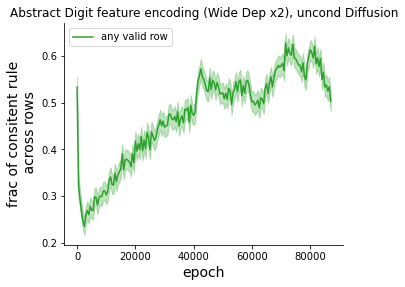

In [142]:

fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.spines[['right', 'top']].set_visible(False)
CI_low, CI_high = estimate_CI((consistent_mat_wide != 0).sum(axis=1), 2048, alpha=0.05)
shaded_error(plt.gca(), epoch_list[:len(consistent_mat_wide)], (consistent_mat_wide != 0).mean(axis=1),
                CI_low, CI_high, label="any valid row", color="C2")
ax.set_ylabel('frac of consitent rule\n across rows', fontsize=14)
ax.set_xlabel('epoch', fontsize=14)
ax.set_title("Abstract Digit feature encoding (Wide Dep x2), uncond Diffusion")
ax.legend()
fig.savefig("Figures/RAVEN10_abstract_Wide_rule_valid.pdf", dpi=300, )#bbox_inches='tight')
fig.savefig("Figures/RAVEN10_abstract_Wide_rule_valid.png", dpi=300, )#bbox_inches='tight')

### One-hot encoding, Wide, Deep Model result

In [186]:
expdir = "/n/holylabs/LABS/kempner_fellows/Users/binxuwang/DL_Projects/mini_edm/exps/Wide_RAVEN10_abstract_onehot_20240206-2324/samples"
epoch_list = list(np.arange(0, 1000000, 5000))
rules_all_onehot_wide = []
for epoch in tqdm(epoch_list): 
    if not os.path.exists(expdir+'/tensor_'+str(epoch)+'.pt'):
        print(epoch, "not exist")
        break
    samples = torch.load(expdir+'/tensor_'+str(epoch)+'.pt') # (batch, 27, 9, 9)
    attr_tsr_list = onehot2attr_tsr(samples, threshold=0.5)
    # attr_tsr_list = torch.round(samples).int() # (batch, 3, 9, 9)
    rules_list = []
    for i, attr_tsr in enumerate(attr_tsr_list): 
        rule_img = get_rule_img(attr_tsr) # (3, 9, 9) -> (3,)
        rules_list.append(rule_img)
    rules_all_onehot_wide.append(rules_list)
rules_all_onehot_wide = np.asarray(rules_all_onehot_wide) # (201, 25, 3)

consistent_mat_onehot_wide = []
for epoch_i in trange(len(rules_all_onehot_wide)): 
    rules_all = rules_all_onehot_wide[epoch_i]
    consistent_all = [check_consistent(rules) for rules in rules_all]
    consistent_mat_onehot_wide.append(consistent_all)
consistent_mat_onehot_wide = np.asarray(consistent_mat_onehot_wide)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 95.91it/s]


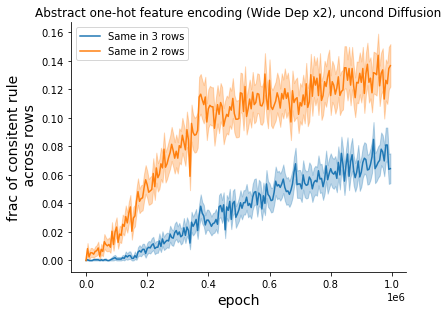

In [187]:
epoch_list = list(np.arange(0, 1000000, 5000))[:len(consistent_mat_onehot_wide)]
fig, ax = plt.subplots(1, 1, figsize=(6,4.5))
ax.spines[['right', 'top']].set_visible(False)
CI_low, CI_high = estimate_CI((consistent_mat_onehot_wide == 1).sum(axis=1), 2048, alpha=0.05)
shaded_error(plt.gca(), epoch_list, (consistent_mat_onehot_wide == 1).mean(axis=1),
                CI_low, CI_high, label="Same in 3 rows", color="C0")
CI_low, CI_high = estimate_CI((consistent_mat_onehot_wide == 2).sum(axis=1), 2048, alpha=0.05)
shaded_error(plt.gca(), epoch_list, (consistent_mat_onehot_wide==2).mean(axis=1),
                CI_low, CI_high, label="Same in 2 rows", color="C1")
ax.set_ylabel('frac of consitent rule\n across rows', fontsize=14)
ax.set_xlabel('epoch', fontsize=14)
ax.set_title("Abstract one-hot feature encoding (Wide Dep x2), uncond Diffusion")
ax.legend()
fig.savefig("Figures/RAVEN10_abstract_onehot_Wide_rule_consistency.pdf", dpi=300, )#bbox_inches='tight')
fig.savefig("Figures/RAVEN10_abstract_onehot_Wide_rule_consistency.png", dpi=300, )#bbox_inches='tight')

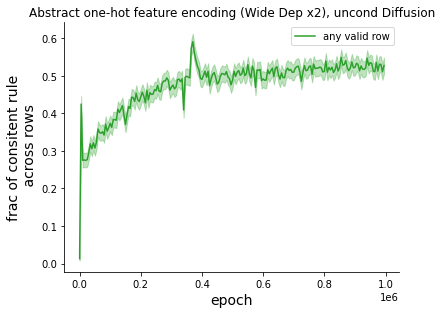

In [188]:
epoch_list = list(np.arange(0, 1000000, 5000))[:len(consistent_mat_onehot_wide)]
fig, ax = plt.subplots(1, 1, figsize=(6,4.5))
ax.spines[['right', 'top']].set_visible(False)
CI_low, CI_high = estimate_CI((consistent_mat_onehot_wide != 0).sum(axis=1), 2048, alpha=0.05)
shaded_error(plt.gca(), epoch_list, (consistent_mat_onehot_wide != 0).mean(axis=1),
                CI_low, CI_high, label="any valid row", color="C2")
ax.set_ylabel('frac of consitent rule\n across rows', fontsize=14)
ax.set_xlabel('epoch', fontsize=14)
ax.set_title("Abstract one-hot feature encoding (Wide Dep x2), uncond Diffusion")
ax.legend()
fig.savefig("Figures/RAVEN10_abstract_onehot_Wide_rule_valid.pdf", dpi=300, )#bbox_inches='tight')
fig.savefig("Figures/RAVEN10_abstract_onehot_Wide_rule_valid.png", dpi=300, )#bbox_inches='tight')

             timestamp level  step  learning_rate  average_loss  batch_loss
0  2024-02-06 23:24:47  INFO     0       0.000000      1.991650    1.991650
1  2024-02-06 23:24:56  INFO   100       0.000004      2.072678    1.998352
2  2024-02-06 23:25:01  INFO   200       0.000008      1.895700    1.505616
3  2024-02-06 23:25:07  INFO   300       0.000012      1.716550    1.215978
4  2024-02-06 23:25:12  INFO   400       0.000016      1.571327    1.094095


<Axes: xlabel='step'>

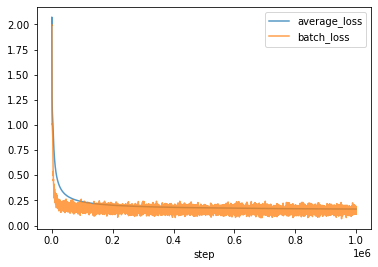

In [194]:
expdir = "/n/holylabs/LABS/kempner_fellows/Users/binxuwang/DL_Projects/mini_edm/exps/Wide_RAVEN10_abstract_onehot_20240206-2324/samples"
df = parse_train_logfile(join(expdir, "..", "std.log"))
df.plot(x="step", y=["average_loss","batch_loss"], alpha=0.75)

In [195]:
np.savez(join(expdir,"samples_inferred_rule_consistency.npz"), 
         consistent_mat=consistent_mat_onehot_wide, 
         rules_all=rules_all_onehot_wide,
         epoch_list=epoch_list)

### Sanity Check: Infer rule on training set

In [ ]:
def load_PGM_abstract(attr): 
    """attr: (3, 9, 3), (num_panel, num_pos, num_attr)"""
    attr = attr.to(int)
    attr = torch.cat(tuple(attr.view(3, 3, 3, 3)), dim=1) # [3, 3, 3, 3] -> [3, 9, 3]
    inputs = attr.permute(2, 0, 1) # num_attr, num_row=3, num_col (n panel x 3)
    return inputs 

In [20]:
d_PGM = torch.load('PGM_shape_size_color_normalized.pt') 
train_inputs = torch.load('train_inputs.pt') # [35, 10000, 3, 9, 3]
print(train_inputs.shape)

torch.Size([35, 10000, 3, 9, 3])


In [28]:
load_PGM_abstract(train_inputs[0, 0]).shape

torch.Size([3, 3, 9])

In [55]:
mtg = torch.cat([load_PGM_abstract(train_inputs[5, 2]),
                 load_PGM_abstract(train_inputs[2, 0]),
                 load_PGM_abstract(train_inputs[33, 6]),], dim=1)
get_rule_img(mtg)

array([ 7,  4, -1])

In [63]:
failed_cnt = 0
for class_id in range(35):
    sample_id = random.choice(range(10000))
    infer_rule_id = get_rule_img(load_PGM_abstract(train_inputs[class_id, sample_id]))
    print(class_id, infer_rule_id[0], "infer failed " if infer_rule_id[0] == -1 else "")
    failed_cnt += (infer_rule_id[0] == -1)

print(failed_cnt, "failed inference")

0 1 
1 3 
2 4 
3 -1 infer failed 
4 -1 infer failed 
5 7 
6 -1 infer failed 
7 9 
8 10 
9 11 
10 12 
11 14 
12 -1 infer failed 
13 -1 infer failed 
14 17 
15 -1 infer failed 
16 19 
17 21 
18 22 
19 23 
20 24 
21 -1 infer failed 
22 -1 infer failed 
23 27 
24 -1 infer failed 
25 29 
26 30 
27 31 
28 32 
29 33 
30 34 
31 -1 infer failed 
32 -1 infer failed 
33 33 
34 39 
11 failed inference


In [178]:
failed_cnt = 0
failed_total = 0
inconsistent_cnt = 0
batchsize = 100
for class_id in range(35):
    sample_ids = np.random.randint(0, 10000, batchsize)
    mtg = torch.cat([load_PGM_abstract(train_inputs[class_id, sample_id]) for sample_id in sample_ids], dim=1)
    infer_rule_id = get_rule_img(mtg)
    is_inconsistent = (len(np.unique(infer_rule_id)) > 1)
    # print("gt", class_id, "infer", infer_rule_id, )
    failed_cnt += (infer_rule_id == -1).any()
    failed_total += (infer_rule_id == -1).sum()
    inconsistent_cnt += is_inconsistent

failed_ratio = failed_total / (35 * batchsize)
print(f"Over 35 classes, each with {batchsize} samples,")
print(failed_cnt, "failed inference", )
print(f"failed ratio {failed_ratio:.3f} ({failed_total} / {35 * batchsize})")
print(inconsistent_cnt, "inconsistent inference (different infered rule from the same class.)")

Over 35 classes, each with 100 samples,
31 failed inference
failed ratio 0.352 (1231 / 3500)
30 inconsistent inference (different infered rule from the same class.)


In [75]:
failed_cnt = 0
inconsistent_cnt = 0
for class_id in range(35):
    sample_ids = np.random.randint(0, 10000, 10)
    mtg = torch.cat([load_PGM_abstract(train_inputs[class_id, sample_id]) for sample_id in sample_ids], dim=1)
    infer_rule_id = get_rule_img(mtg)
    print("gt", class_id, "infer", infer_rule_id, )
    failed_cnt += (infer_rule_id == -1).any()
    inconsistent_cnt += (len(np.unique(infer_rule_id)) > 1)

print(failed_cnt, "failed inference")
print(inconsistent_cnt, "inconsistent inference")

gt 0 infer [1 1 1 1 1 1 1 1 1 1]
gt 1 infer [3 3 3 3 3 3 3 3 3 3]
gt 2 infer [4 4 4 4 4 4 4 4 4 4]
gt 3 infer [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
gt 4 infer [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
gt 5 infer [7 7 7 7 7 7 7 7 7 7]
gt 6 infer [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
gt 7 infer [ 9  9  9  9  9  9  9  9  9 -1]
gt 8 infer [10 10 10 -1 10 10 10 10 10 10]
gt 9 infer [11 11 11 11 11 11 11 11 11 11]
gt 10 infer [12 12 12 12 12 12 -1 12 12 12]
gt 11 infer [14 14 14 14 14 14 14 14 14 14]
gt 12 infer [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
gt 13 infer [-1 -1  7 -1 -1 -1 -1 -1 -1 -1]
gt 14 infer [17 17 17 17 17 17 17 17 17 17]
gt 15 infer [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
gt 16 infer [19 19 19 19 19 19 19 19 19 19]
gt 17 infer [21 21 21 21 21 21 21 21 21 21]
gt 18 infer [22 -1 22 22 22 22 -1 22 22 22]
gt 19 infer [23 23 23 23 23 23 23 23 -1 23]
gt 20 infer [24 24 24 24 24 24 24 24 24 24]
gt 21 infer [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
gt 22 infer [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
gt 23 infer [27 27 27 27 27 27 27 27 2